In [2]:
import os
import pandas as pd
import torchvision.models as models
from fastai.vision.all import *
from fastai.distributed import *
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import click, argparse
import warnings
import torchvision.models as models
warnings.filterwarnings('ignore')

Reading images for training from train.txt 
and for validation from valid.txt 

Aim is to get the highest R2 score on validation data 

In [3]:
train_img_files = pd.read_csv("train.txt", names=["imgs"])
train_img_files = train_img_files["imgs"]

print(f"Total images for training are {len(train_img_files)}")

valid_img_files = pd.read_csv("valid.txt", names=["imgs"])

valid_img_files = valid_img_files["imgs"]

print(f"Total images for validation are {len(valid_img_files)}")

Total images for training are 672
Total images for validation are 289


We will use sklearn to standardise our data. We will first calculate the mean and variance of the 4 features and then scale the data to have zero mean and 1 variance. 

For more info [see](https://scikit-learn.org/stable/modules/preprocessing.html#standardization-or-mean-removal-and-variance-scaling)

In [4]:
sc = StandardScaler()

In [5]:
def get_df(img_files,train_data=True):
    ku1, alphas, aexs, temp    = [],[],[],[]
    for ii, value in enumerate(img_files):
        value = value.split("/")[-1]
        if len(value.split('_')) == 4:
            ku1.append(value.split('_')[0])
            alphas.append(value.split('_')[1])
            aexs.append(value.split('_')[2])
            temp.append(value.split('_')[3].strip('.jpg'))
            
    ku1    = pd.Series(ku1,    name='ku1').astype(int)
    alphas = pd.Series(alphas, name='alphas').astype(float)
    aexs   = pd.Series(aexs,   name='aexs').astype(float)
    temp   = pd.Series(temp,   name='temp').astype(float)
    
    
    df = pd.concat([img_files, ku1, alphas, aexs, temp], 
                   axis=1).sample(frac=1.0, random_state=1).reset_index(drop=True)
    if (train_data):
        normVal= sc.fit_transform(df.values[:,1:]) # for training data 
    else:
        normVal= sc.transform(df.values[:,1:]) # for test data 
    df['nku1'],df['nalphas'],df['naexs'],df['ntemp'] = normVal[:,0],normVal[:,1], normVal[:,2], normVal[:,3]
    return df

We call transform on validation data so that mean and variance of the training data is used to standadize the validating data. 

In [6]:
df_train = get_df(train_img_files,train_data=True)
df_valid = get_df(valid_img_files,train_data=False)

In [7]:
df_train

,imgs,ku1,alphas,aexs,temp,nku1,nalphas,naexs,ntemp
0,data/500000_0.825_2.3e-11_263.jpg,500000,0.825,2.300000e-11,263.0,-0.366844,-1.588880,-0.576402,-0.856867
1,data/1000000_0.85_1.03e-10_300.jpg,1000000,0.850,1.030000e-10,300.0,-0.181545,-0.993383,0.514468,-0.696964
2,data/5000000_0.875_2.3e-10_338.jpg,5000000,0.875,2.300000e-10,338.0,1.300841,-0.397885,2.246226,-0.532739
3,data/700000_0.9_1.6e-11_950.jpg,700000,0.900,1.600000e-11,950.0,-0.292724,0.197613,-0.671853,2.112140
4,data/900000_0.9_1e-11_950.jpg,900000,0.900,1.000000e-11,950.0,-0.218605,0.197613,-0.753669,2.112140
...,...,...,...,...,...,...,...,...,...
667,data/500000_0.9_1e-10_550.jpg,500000,0.900,1.000000e-10,550.0,-0.366844,0.197613,0.473561,0.383461
668,data/50000_0.875_2.3e-11_263.jpg,50000,0.875,2.300000e-11,263.0,-0.533612,-0.397885,-0.576402,-0.856867
669,data/10000000_0.85_1.03e-11_275.jpg,10000000,0.850,1.030000e-11,275.0,3.153825,-0.993383,-0.749578,-0.805006
670,data/1100000_0.9_1e-11_450.jpg,1100000,0.900,1.000000e-11,450.0,-0.144486,0.197613,-0.753669,-0.048709


We need to get an idea about the maximum and minimum value of each of the outputs. This is required when we want to use pretrained networks. The outerlayer of such pretrained networks is sigmoid and we need to define a range of the expected outcomes. 

In [8]:
def get_x(r):
    r = r["imgs"]
    image = Image.open(r, mode="r")
    image = image.convert('RGB')
    image = image.resize((256,256))
    return tensor(image)

def get_y(r):
    return tensor([r['nku1'],r['nalphas'],r['naexs'],r['ntemp']])

In [9]:
dblock = DataBlock((ImageBlock, RegressionBlock),
                           get_x = get_x, get_y = get_y,
                           splitter = RandomSplitter(valid_pct=0.0),
                           batch_tfms=[*aug_transforms(size=(256,256)),
                                       Normalize.from_stats(*imagenet_stats)]) 

dls = dblock.dataloaders(df_train, bs=32, shuffle=True) # training data 
dls_valid = dblock.dataloaders(df_valid, bs=32, shuffle=True) # validation data  
dls.valid = dls_valid.train # updating validation data of training dataloader 

print (f"Dataloader has {len(dls.train.items)} training images and {len(dls.valid.items)} validating images")

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck
Dataloader has 672 training images and 289 validating images


In [10]:
images , values = dls.one_batch() # getting sense of one batch 
print(images[0].shape , values[0]) # getting sense of one datapoint of a batch 

torch.Size([3, 256, 256]) tensor([ 1.3008,  1.9841, -0.7496, -0.8569])


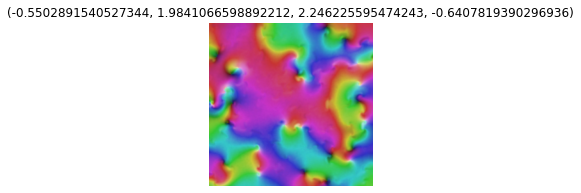

In [11]:
dls.show_batch(nrows=1, ncols=1)

In [27]:
efficientnet_b3 = models.efficientnet_b3()

In [28]:
callbacks=([SaveModelCallback(monitor='valid_loss',with_opt=True ), # saving best model 
            EarlyStoppingCallback(monitor='valid_loss',patience=100,)]) # stopping training if calid loss does not improve 

learn = cnn_learner(dls, 
                    efficientnet_b3,
                    pretrained=True, 
                    y_range=(-4.0,4.0), 
                    metrics=[mse,mae], 
                    cbs=callbacks) # y_range=(0,data.max())

TypeError: forward() got an unexpected keyword argument 'pretrained'

In [26]:
learn.lr_find()

RuntimeError: The size of tensor a (32000) must match the size of tensor b (128) at non-singleton dimension 0

In [20]:
learn.fit_one_cycle(5, 1.0e-4)

epoch,train_loss,valid_loss,error_rate,time


RuntimeError: The size of tensor a (32000) must match the size of tensor b (128) at non-singleton dimension 0

In [ ]:
pre_results = learn.get_preds()

In [ ]:
r2_score(pre_results[1],pre_results[0])

In [ ]:
learn.unfreeze()
learn.lr_find()
learn.fit_one_cycle(500, 1.0e-4)

In [ ]:
post_results = learn.get_preds()

In [ ]:
r2_score(post_results[1], post_results[0])

In [ ]:
learn.opt.param_groups[0]

In [ ]:
fr = open('../../Image_Regression_Mag/NN_Uday/Unfreeze.txt', 'r')

In [ ]:
epoch,train_loss,valid_loss,mse,mae = [],[],[],[],[]
for ii in fr.readlines():
    values = ii.split('\t')
    epoch.append(values[0])
    train_loss.append(values[1])
    valid_loss.append(values[2])
    mse.append(values[3])
    mae.append(values[4])

In [ ]:
df = pd.DataFrame()
df['epochs'] = epoch[1:]
df['train_loss'] = train_loss[1:]
df['valid_loss'] = valid_loss[1:]
df['mse'] = mse[1:]
df['mae'] = mae[1:]
df = df.apply(pd.to_numeric, errors='coerce')

In [ ]:
plt.plot(df['train_loss'], label='train')
plt.plot(df['valid_loss'], label='test')
plt.legend()

In [ ]:
with open('../../Image_Regression_Mag/NN_Uday/Freeze.txt', 'r') as f:
    print(f.readlines())